<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [132]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [133]:
response = requests.get(url)
response

<Response [200]>

In [134]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'inspection_persons', 'inspection_status_summary', 'lastUpdate', 'main_summary'])

In [135]:
# 日毎の数
patients_count = [data['小計'] for data in j_res['patients_summary']['data']]

In [136]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [137]:
# 日付をインデックスにした日毎の数のデータフレーム
patients_df = pd.DataFrame(
    {'patients_count': patients_count},
    index=pd.date_range(
        start=utc_datestr_to_jst_date(j_res['patients_summary']['data'][0]['日付']),
        end=utc_datestr_to_jst_date(j_res['patients_summary']['data'][-1]['日付']),
        freq='D'))
patients_df['datetime'] = patients_df.index
patients_df.tail()

,patients_count,datetime
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00


In [138]:
# 7日移動平均
patients_df['7d_mov_ave'] = patients_df.rolling('7D').mean()
patients_df.tail()

,patients_count,datetime,7d_mov_ave
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429


In [139]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
patients_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in patients_df.index]
patients_df.tail()

,patients_count,datetime,7d_mov_ave,week_num
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143,'20w30
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714,'20w30
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429,'20w30
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714,'20w30
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429,'20w30


In [140]:
# 曜日の列をセット
patients_df['week_day'] = [d.strftime('%a') for d in patients_df.index]
patients_df.tail(15)

,patients_count,datetime,7d_mov_ave,week_num,week_day
2020-07-12 17:00:00+09:00,206,2020-07-12 17:00:00+09:00,166.000000,'20w28,Sun
2020-07-13 17:00:00+09:00,119,2020-07-13 17:00:00+09:00,168.428571,'20w29,Mon
2020-07-14 17:00:00+09:00,143,2020-07-14 17:00:00+09:00,173.714286,'20w29,Tue
2020-07-15 17:00:00+09:00,165,2020-07-15 17:00:00+09:00,186.571429,'20w29,Wed
2020-07-16 17:00:00+09:00,286,2020-07-16 17:00:00+09:00,195.428571,'20w29,Thu
2020-07-17 17:00:00+09:00,293,2020-07-17 17:00:00+09:00,202.571429,'20w29,Fri
2020-07-18 17:00:00+09:00,290,2020-07-18 17:00:00+09:00,214.571429,'20w29,Sat
2020-07-19 17:00:00+09:00,188,2020-07-19 17:00:00+09:00,212.000000,'20w29,Sun
2020-07-20 17:00:00+09:00,168,2020-07-20 17:00:00+09:00,219.000000,'20w30,Mon
2020-07-21 17:00:00+09:00,237,2020-07-21 17:00:00+09:00,232.428571,'20w30,Tue


In [141]:
# 週毎に集計
groupby_week_num = patients_df.groupby('week_num')
groupby_week_num

In [142]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': patients_df['week_num'].unique(),
    'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
week_num_df.tail()

,week_num,week_mean,week_sum
2020-06-28 17:00:00+09:00,'20w26,47.714286,334
2020-07-05 17:00:00+09:00,'20w27,93.142857,652
2020-07-12 17:00:00+09:00,'20w28,166.000000,1162
2020-07-19 17:00:00+09:00,'20w29,212.000000,1484
2020-07-26 17:00:00+09:00,'20w30,257.571429,1803


In [161]:
df = pd.concat([
                patients_df,
                week_num_df.loc[:, ['week_mean', 'week_sum']]
                ], axis=1)
df.tail(15)

,patients_count,datetime,7d_mov_ave,week_num,week_day,week_mean,week_sum
2020-07-12 17:00:00+09:00,206,2020-07-12 17:00:00+09:00,166.000000,'20w28,Sun,166.000000,1162.0
2020-07-13 17:00:00+09:00,119,2020-07-13 17:00:00+09:00,168.428571,'20w29,Mon,NaN,NaN
2020-07-14 17:00:00+09:00,143,2020-07-14 17:00:00+09:00,173.714286,'20w29,Tue,NaN,NaN
2020-07-15 17:00:00+09:00,165,2020-07-15 17:00:00+09:00,186.571429,'20w29,Wed,NaN,NaN
2020-07-16 17:00:00+09:00,286,2020-07-16 17:00:00+09:00,195.428571,'20w29,Thu,NaN,NaN
2020-07-17 17:00:00+09:00,293,2020-07-17 17:00:00+09:00,202.571429,'20w29,Fri,NaN,NaN
2020-07-18 17:00:00+09:00,290,2020-07-18 17:00:00+09:00,214.571429,'20w29,Sat,NaN,NaN
2020-07-19 17:00:00+09:00,188,2020-07-19 17:00:00+09:00,212.000000,'20w29,Sun,212.000000,1484.0
2020-07-20 17:00:00+09:00,168,2020-07-20 17:00:00+09:00,219.000000,'20w30,Mon,NaN,NaN
2020-07-21 17:00:00+09:00,237,2020-07-21 17:00:00+09:00,232.428571,'20w30,Tue,NaN,NaN


### グラフ出力

In [162]:
### 日毎の数
x = df.index
y1_1 = df['patients_count']
y1_2 = df['7d_mov_ave']
y1_3 = df['week_mean']

In [163]:
### 週毎の数
x2 = week_num_df['week_num']
y2_1 = week_num_df['week_mean']
y2_2 = week_num_df['week_sum']

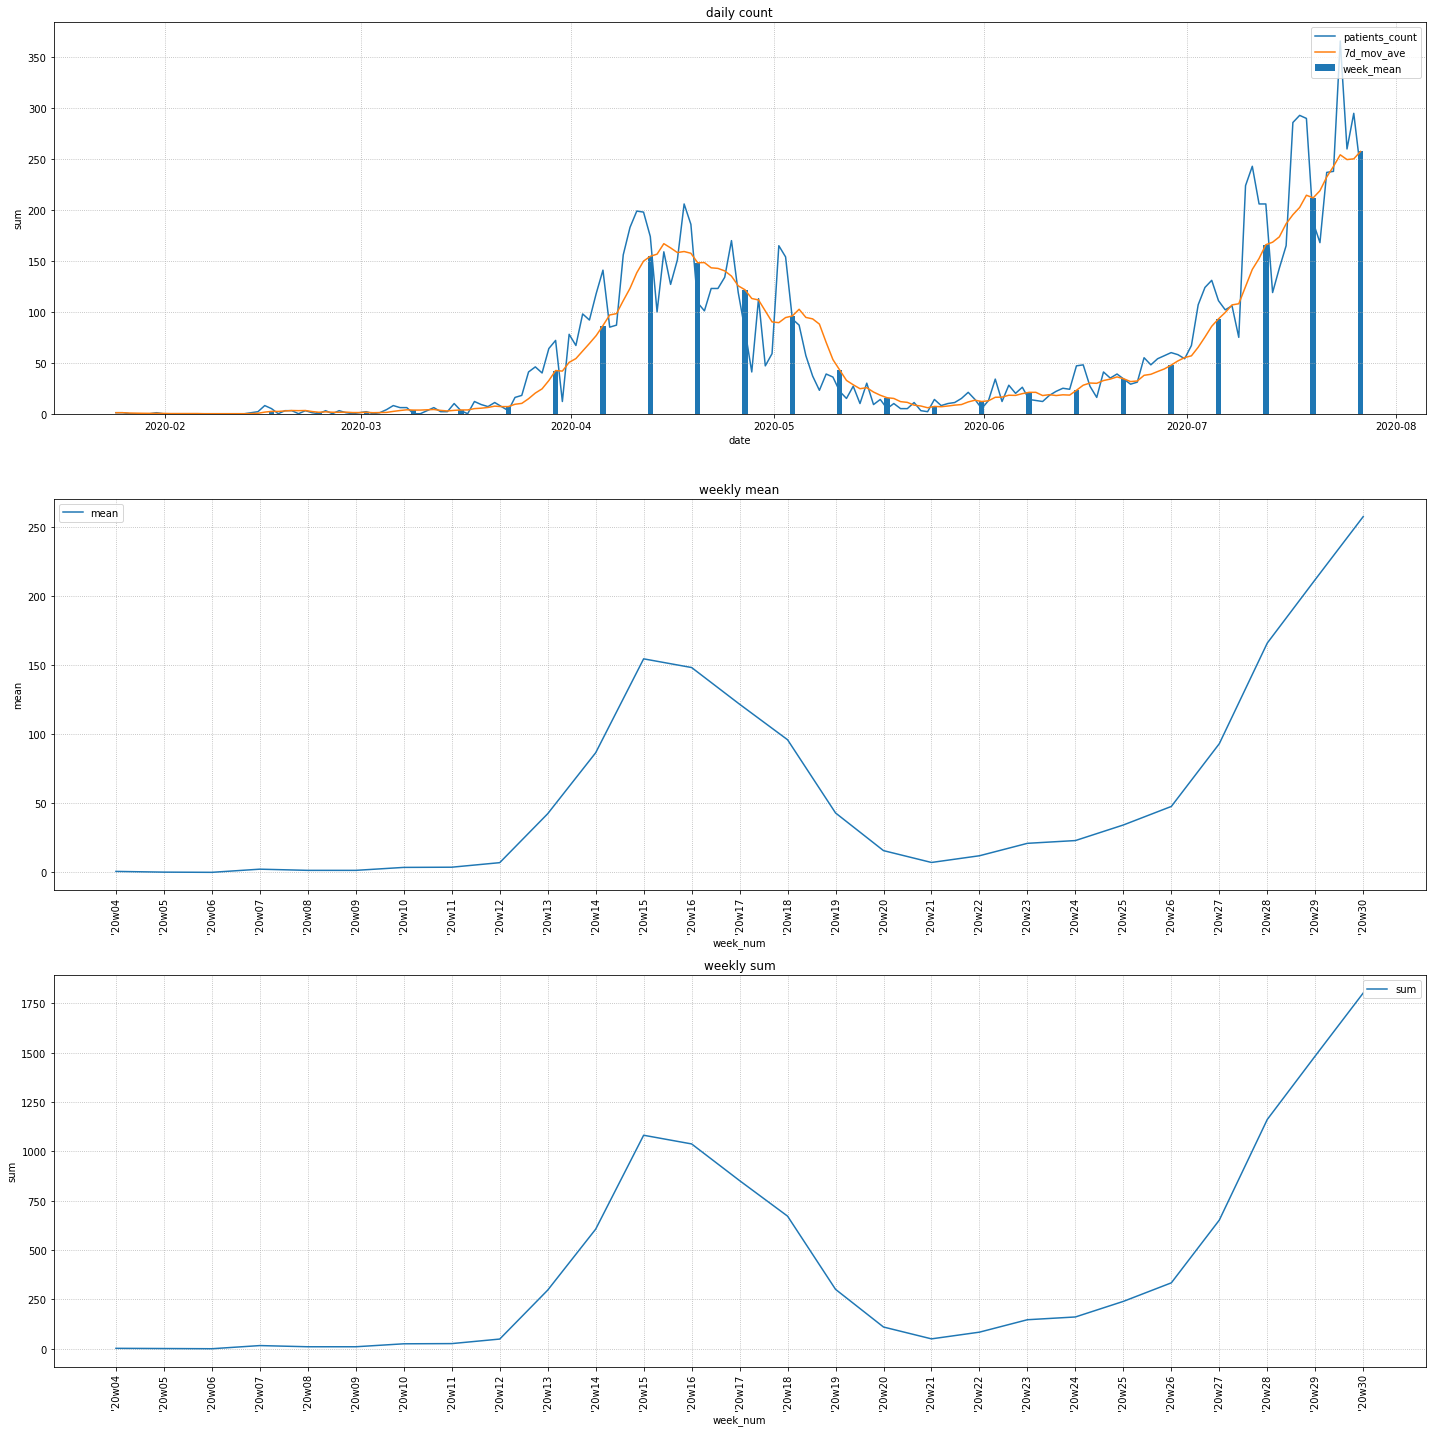

In [164]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='7d_mov_ave')
ax[0].bar(x, y1_3, label='week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
ax[1].set_title('weekly mean')
ax[1].set_xticklabels(labels=x2, rotation=90)
ax[1].set_xlabel('week_num')
ax[1].set_ylabel('mean')
ax[1].plot(x2, y2_1, label='mean')
ax[1].grid(linestyle=':')
ax[1].legend()

### 週毎の合計
ax[2].set_title('weekly sum')
ax[2].set_xticklabels(labels=x2, rotation=90)
ax[2].set_xlabel('week_num')
ax[2].set_ylabel('sum')
ax[2].plot(x2, y2_2, label='sum')
ax[2].grid(linestyle=':')
ax[2].legend()

plt.tight_layout()

---

In [ ]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
em_days = []
for i in range((em_end - em_start).days + 1):
  em_days.append(em_start + datetime.timedelta(i))

In [ ]:
year = []
month = []
day = []
for d in sub_df['datetime.date']:
  year.append(int(d.strftime('%Y')))
  month.append(int(d.strftime('%m')))
  day.append(int(d.strftime('%d')))

In [ ]:
ds_df = sub_df

# 年
ds_df['year'] = year
# 月
ds_df['month'] = month
# 日
ds_df['day'] = day
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
# 経過日数
ds_df['passed'] = [(d - ds_df['datetime.date'][0]).days for d in ds_df['datetime.date']]
# 緊急事態宣言
ds_df['emergency'] = [int(datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d') in em_days) for d in ds_df['datetime.date']]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [((datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d') - em_start).days if em_start < datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d') else 0) for d in ds_df['datetime.date']]
# 検査数

ds_df

,日付,小計,datetime.date,week_num,week_day,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed
0,2020-01-24T08:00:00.000Z,1,2020-01-24 17:00:00+09:00,'20w04,Fri,2020,1,24,1,0,0,0,0,0,0,0,0,0
1,2020-01-25T08:00:00.000Z,1,2020-01-25 17:00:00+09:00,'20w04,Sat,2020,1,25,0,0,1,0,0,0,0,1,0,0
2,2020-01-26T08:00:00.000Z,0,2020-01-26 17:00:00+09:00,'20w04,Sun,2020,1,26,0,0,0,1,0,0,0,2,0,0
3,2020-01-27T08:00:00.000Z,0,2020-01-27 17:00:00+09:00,'20w05,Mon,2020,1,27,0,1,0,0,0,0,0,3,0,0
4,2020-01-28T08:00:00.000Z,0,2020-01-28 17:00:00+09:00,'20w05,Tue,2020,1,28,0,0,0,0,0,1,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2020-07-22T08:00:00.000Z,238,2020-07-22 17:00:00+09:00,'20w30,Wed,2020,7,22,0,0,0,0,0,0,1,180,0,106
181,2020-07-23T08:00:00.000Z,366,2020-07-23 17:00:00+09:00,'20w30,Thu,2020,7,23,0,0,0,0,1,0,0,181,0,107
182,2020-07-24T08:00:00.000Z,260,2020-07-24 17:00:00+09:00,'20w30,Fri,2020,7,24,1,0,0,0,0,0,0,182,0,108
183,2020-07-25T08:00:00.000Z,295,2020-07-25 17:00:00+09:00,'20w30,Sat,2020,7,25,0,0,1,0,0,0,0,183,0,109


In [ ]:
ds_df = ds_df.drop(columns=['日付', '小計', 'datetime.date', 'week_num', 'week_day'])
ds_df = pd.concat([ds_df, sub_df['小計']], axis=1)
ds_df

,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,小計
0,2020,1,24,1,0,0,0,0,0,0,0,0,0,1
1,2020,1,25,0,0,1,0,0,0,0,1,0,0,1
2,2020,1,26,0,0,0,1,0,0,0,2,0,0,0
3,2020,1,27,0,1,0,0,0,0,0,3,0,0,0
4,2020,1,28,0,0,0,0,0,1,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2020,7,22,0,0,0,0,0,0,1,180,0,106,238
181,2020,7,23,0,0,0,0,1,0,0,181,0,107,366
182,2020,7,24,1,0,0,0,0,0,0,182,0,108,260
183,2020,7,25,0,0,1,0,0,0,0,183,0,109,295


In [ ]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   year       185 non-null    int64
 1   month      185 non-null    int64
 2   day        185 non-null    int64
 3   Fri        185 non-null    uint8
 4   Mon        185 non-null    uint8
 5   Sat        185 non-null    uint8
 6   Sun        185 non-null    uint8
 7   Thu        185 non-null    uint8
 8   Tue        185 non-null    uint8
 9   Wed        185 non-null    uint8
 10  passed     185 non-null    int64
 11  emergency  185 non-null    int64
 12  em_passed  185 non-null    int64
 13  小計         185 non-null    int64
dtypes: int64(7), uint8(7)
memory usage: 11.5 KB


In [ ]:
ds_df.describe()

,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,小計
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.00000,185.000000
mean,2020.0,4.302703,15.827027,0.145946,0.140541,0.145946,0.145946,0.140541,0.140541,0.140541,92.000000,0.264865,33.00000,60.616216
std,0.0,1.786192,8.799847,0.354010,0.348490,0.354010,0.354010,0.348490,0.348490,0.348490,53.549043,0.442459,36.73273,77.656495
min,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,0.00000,3.000000
50%,2020.0,4.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000,18.00000,24.000000
75%,2020.0,6.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138.000000,1.000000,64.00000,100.000000
max,2020.0,7.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,184.000000,1.000000,110.00000,366.000000


In [ ]:
ds_df.corr()

,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,小計
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,1.000000,-0.149824,-0.010082,-0.007598,-1.486677e-03,0.007108,0.009864,-0.007598,0.009864,9.867386e-01,0.069920,0.922423,0.546634
day,NaN,-0.149824,1.000000,0.015126,-0.022157,8.147670e-03,0.004659,0.007970,0.023920,-0.038107,1.245601e-02,-0.009107,0.028684,-0.029237
Fri,NaN,-0.010082,0.015126,1.000000,-0.167163,-1.708861e-01,-0.170886,-0.167163,-0.167163,-0.167163,-7.740670e-03,-0.005251,-0.001254,0.076381
Mon,NaN,-0.007598,-0.022157,-0.167163,1.000000,-1.671635e-01,-0.167163,-0.163522,-0.163522,-0.163522,-1.135807e-02,0.004001,-0.014010,-0.110055
Sat,NaN,-0.001487,0.008148,-0.170886,-0.167163,1.000000e+00,-0.170886,-0.167163,-0.167163,-0.167163,-1.527799e-18,-0.005251,0.005433,0.073218
Sun,NaN,0.007108,0.004659,-0.170886,-0.167163,-1.708861e-01,1.000000,-0.167163,-0.167163,-0.167163,7.740670e-03,-0.005251,0.012120,-0.001510
Thu,NaN,0.009864,0.007970,-0.167163,-0.163522,-1.671635e-01,-0.167163,1.000000,-0.163522,-0.163522,1.135807e-02,0.004001,0.005944,0.063456
Tue,NaN,-0.007598,0.023920,-0.167163,-0.163522,-1.671635e-01,-0.167163,-0.163522,1.000000,-0.163522,-3.786024e-03,0.004001,-0.007642,-0.047399
Wed,NaN,0.009864,-0.038107,-0.167163,-0.163522,-1.671635e-01,-0.167163,-0.163522,-0.163522,1.000000,3.786024e-03,0.004001,-0.000849,-0.056436
